# Predictive Information optimized Reservoir

Consider a discrete-time RNN with dynamics given by

$$x_{t+1} = f(A x_{t} + u_t + b)$$

Where $A$ is the connectivity matrix, $b$ is the bias vector, $u_t$ is input and $f$ is some nonlinear function, e.g. RELU. Further, to exclude exploding behaviour, limit $x \in [0, 1]$ for all neurons

For simplicity, assume $u_t = 0$ and initial state $x_0$ taken from some random distribution. Running the system produces a markov chain $x_t$ of order 1, since the future state $x_{t+1}$ is fully determined by 1 previous timestep $x_t$.

The goal of this study is to find a set of parameters $A$ and $b$ for which the system would consistently produce complex non-trivial dynamics. More precisely, its dynamics should satisfy the following conditions:
* Semi-Determinism: The future state of the system should be predictable from past states to a large extent
* Time-evolution: For any non-tribvial initialization, the system should explore phase space as function of time, as opposed to settling into a small subspace
* Non-convergence: For sufficiently varied initial conditions, the system at a far-away future timestep $t$ explores the phase-space, as opposed to converging.

Given $N$ runs of a system for duration $T$ each, the dataset $x_{it}$ is obtained. In mathematical terms, the above conditions can be approximated as follows:
* Determinism: $L_1 = \frac{1}{T-1}\sum_t I(x_{t+1} : x_t) \rightarrow \max$
* Time-evolution: $L_2 = \frac{1}{N}\sum_i H(x_i) \rightarrow \max$
* Non-convergence: $L_3 = \frac{1}{T}\sum_t H(x_t) \rightarrow \max$

Since mutual information $I(x_{t+1} : x_t) = H(x_t) + H(x_{t+1}) - H(x_t x_{t+1})$ is maximized when individual entropies are high, but joint entropy is low, the `determinism` condition is a strictly stronger requirement than the `non-convergence` condition, thus the latter can be dropped.

## Optimization problem

So the goal is to find parameters $A, b$ which maximize $L = L_1 + L_2$. The problem is likely unsolvable analytically, and further non-differentiable. Still, can perform numeric minimization of stochastic objective function, optimizing $A, b$. If we temporarily focus only on $L_1$, the problem can be further simplified:

1. Instead of computing time-average of mutual informations, it is enough to only perform one time step, since we anyway are randomizing over initial conditions. The functions we seek should be as bijective as possible, so the non-bijective functions will be revealed as they will collapse many initial states to the same state
2. If $y = f(x)$, then $H(XY) = H(X)$, since $Y$ can't gain any extra info compared to $X$, only lose. Thus, the mutual information simplifies to $I(X:Y) = H(X) + H(Y) - H(XY) = H(Y)$.
3. Maybe it is possible to approximate entropy with total variance - only useful if that somehow makes optimization numerically tractable, which I don't expect to be the case

## Under-determined problem - need to reconsider the meaning of this entire task

Problem is: the identity function $A = 1, b=0$ satisfies the determinism constraint. So why exactly does the static memory device not satisfy our needs. Our goals are as follows:

1. The RNN keeps a memory of initial state / any experienced perturbations
2. The RNN performs a bijective rotation on the stored state, allowing different features to be decoded by later layers

Identity function satisfies first but not the second. Movement of information sequentially between neurons kind of satisfies both, but does not really perform any sophisticated operations on the data. So what could be a useful rotation? Something like quantum state time-evolution? Where each fourier component evolves over time.

## Spiky storage

Another constraint we so far did not consider is the medium constraint. A spiking network cannot implement an identity function, the information has to move around. The simplest approximation for this is to fix diagonal entries of $A$ to $-\infty$. This way, a cell cannot spike during immediate next timestep.

Further, the spike-timing is not clock-synchronized, so the hope is that intrinsic periodicity emerges naturally. Finally, it is not trivial how to evaluate predictive information in a time-continuous scenario:
* It has to take account of hidden variables (e.g. membrane potentials), as it must contain info about the entire state, not only the observable one
* It has to compute PI at significant delay. Actions performed by the network (e.g. sub-threshold vs supra-threshold) are heterogenious, so a system needs to perform a representative sample of the actions it can perform before we can conclude to what extent does it destroy information
* The metric used to calculate PI will directly influence how the system stores information. Namely, if a rate-code is used to calculate PI, then the system will be trained to store data in a rate code.

## Plasticity

Most importantly, is it possible to optimize global predictive information by local changes in synaptic plasticity. This is clearly true to some extent
- Homeostatic control of firing threshold and synaptic weight can ensure that all neurons have firing rates in an acceptable range, and adapt to neuronal birth/death.
- Homeostatic control of tonic current may re-spark activity if it dies out
However, it is unclear and very interesting if such local changes are enough to adaptively create a bijective storage, if instead additional plasticity mechanisms are necessary, or if it is theoretically impossible to create global phenomena from purely local changes.

# 1. Discrete RNN with global optimization

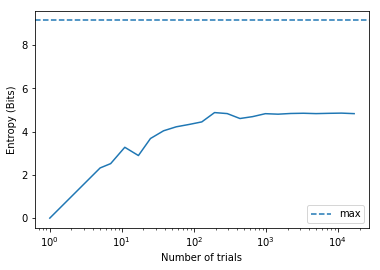

In [64]:
'''
Step 1. Check how much information is destroyed by a random network in a single timestep
'''

import numpy as np
import matplotlib.pyplot as plt

# Single timestep for a linear threshold model
def discrete_step(x, A, b, nu=0):
    return (x.dot(A) + nu > b).astype(int)

# For each unique row find number of such rows
def count_unique_rows(arr2D):
    dt = np.dtype((np.void, arr2D.dtype.itemsize * arr2D.shape[1]))
    b = np.ascontiguousarray(arr2D).view(dt)
    unq, cnt = np.unique(b, return_counts=True)
#     unq = unq.view(arr2D.dtype).reshape(-1, arr2D.shape[1])
#     return unq, cnt
    return cnt

# Compute discrete multivariate entropy
def hnd(data2D):
    stateCounts = count_unique_rows(data2D)
    p = stateCounts / np.sum(stateCounts)
    return -p.dot(np.log2(p))

# Compute the 1D entropy of a random state 
def test_one(A, b, nTest):
    nChannel = A.shape[0]
    x0 = np.random.randint(0, 2, (nTest, nChannel))
    x1 = discrete_step(x0, A, b)
    return hnd(x1)

def plot_test_entropy(A, b):
    nTestLst = (1.5**np.arange(25)).astype(int)
    hLst = [test_one(A, b, nTest) for nTest in nTestLst]

    xExample = np.random.randint(0, 2, (1000, nChannel))
    hExample = hnd(xExample)

    plt.figure()
    plt.semilogx(nTestLst, hLst)
    plt.axhline(y=hExample, linestyle='--', label='max')
    plt.xlabel('Number of trials')
    plt.ylabel('Entropy (Bits)')
    plt.legend()
    plt.show()
    
nChannel = 10
A = np.random.uniform(-1, 1, (nChannel, nChannel))
b = np.random.uniform(-1, 1, nChannel)
plot_test_entropy(A, b)

In [5]:
'''
Step 2. Maximize target entropy by choosing connectivity matrix and bias 

Note:
 Objective function is stochastic - can't use standard scipy routines.
 Tried a specific-designed expectation optimization algorithm - did not converge in 10min
 There should be a way to do this rigorously in some way
'''

# from noisyopt import minimizeCompass

# def pack_vars(A, b):
#     return np.hstack([A.flatten(), b])

# def unpack_vars(x, nChannel):
#     A = x[:-nChannel].reshape((nChannel, nChannel))
#     b = x[-nChannel:]
#     return A, b

# def obj(x):
#     A, b = unpack_vars(x, nChannel)
#     return test_one(A, b, 1000)

# nChannel = 10
# A = np.random.uniform(-1, 1, (nChannel, nChannel))
# b = np.random.uniform(-1, 1, nChannel)

# res = minimizeCompass(obj, x0=pack_vars(A, b), deltatol=0.1, paired=False)

KeyboardInterrupt: 

In [55]:
'''
Step 2.1 Perform approximate stochastic minimization, since canonical algorithms do not seem to converge
'''

def temp_min(f, x0, nStep=1000):
    nX = x0.shape[0]
    x = np.copy(x0)
    rezLst = [(0, f(x))]
    
    for i in range(nStep):
        xNew = x + np.random.normal(0, 0.1, nX)
        xNew = np.clip(xNew, -1, 1) # Forbid too high values as they are useless 
        h = f(xNew)
        if h > rezLst[-1][1]:
            x = xNew
            rezLst += [(i, h)]
            
    return x, rezLst
        
x, hist = temp_min(obj, pack_vars(A, b))
hist

[(0, 5.406800561952909),
 (2, 5.62316045316942),
 (5, 5.796186737604045),
 (6, 6.090519615390219),
 (8, 6.255972656034654),
 (9, 6.587997744877469),
 (10, 6.601366896000411),
 (17, 6.657124544304234),
 (20, 6.9474188698312345),
 (24, 7.14213147955771),
 (25, 7.255882695848677),
 (30, 7.3122842138810995),
 (34, 7.372486032444439),
 (39, 7.451705527205275),
 (55, 7.476626508002575),
 (57, 7.650695569452883),
 (123, 7.6917593747918485),
 (136, 7.716295971030326),
 (141, 7.747319504131987),
 (144, 7.7623154319767425),
 (153, 7.800884967062322),
 (155, 7.856840139555015),
 (263, 7.877478498888761),
 (319, 7.97825195536705),
 (491, 7.994568186749893),
 (498, 8.007588384638764),
 (509, 8.015228157312327),
 (546, 8.017914561015198),
 (550, 8.0483354915979),
 (568, 8.051335962017003),
 (580, 8.093070150491435)]

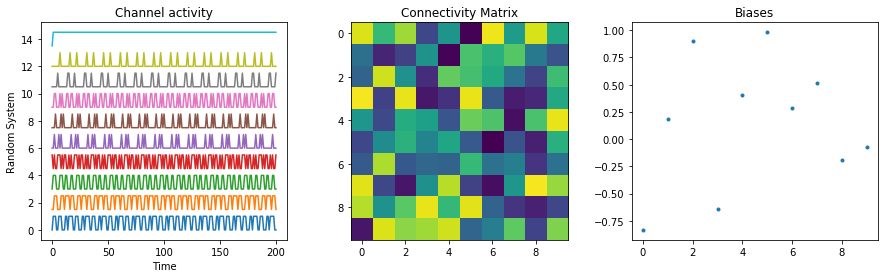

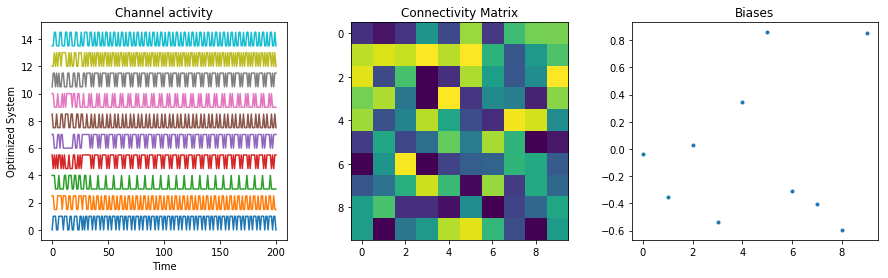

In [91]:
'''
Step 3. Plot example dynamics before and after optimization 
'''

def plot_performance(A, b, nStep, setLabel):
    # Randomly initialize each channel
    xLst = [np.random.randint(0, 2, nChannel)]

    # Compute values some steps forwards
    for i in range(nStep):
        xLst += [discrete_step(xLst[-1], A, b)]

    xArr = np.array(xLst)

    fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
    
    for iCh in range(nChannel):
        ax[0].plot(xArr[:, iCh] + iCh*1.5)
        
    ax[1].imshow(A, vmin=-1, vmax=1)
    ax[2].plot(b, '.')
    ax[0].set_ylabel(setLabel)
    ax[0].set_title('Channel activity')
    ax[1].set_title('Connectivity Matrix')
    ax[2].set_title('Biases')
    ax[0].set_xlabel('Time')
    plt.show()

A = np.random.uniform(-1, 1, (nChannel, nChannel))
b = np.random.uniform(-1, 1, nChannel)
Aopt, bopt = unpack_vars(x, nChannel)

plot_performance(A, b, 200, 'Random System')
plot_performance(Aopt, bopt, 200, 'Optimized System')

# 2. Discrete RNN with Plasticity

The goal of plasticity is to stabilize dynamics, in order not to lose information and have useful neurons

**Goal**: The expected activity $\langle x \rangle \approx x_0$ of a neuron tents towards a fixed value

Design integrator $\tau_y \dot{y} = -y + x$, or discretely $y_{t+1} = (1 - \eta_y)y_t + \eta_y x_t$

**Homeostatic plasticity**: $\tau_b \dot{b} = (y - x_0)$, or discretely $b_{t+1} = b_t + \eta_b (y_t - x_0)$

**Synaptic Plasticity**: Adjust plasticity if presynaptic neuron recently fired, and to optimize own firing

Then the plasticity $\tau_A \dot{A}_{ij} = - y_j (y_i - x_0)$, or discretely $A_{ij}^{t+1} = A_{ij}^{t} + \eta_A y_j^t (y_i^t - x_0)$

# 2.1 Homeostatic Plasticity

In [74]:
def y_step(y, x, etaY):
    return (1-etaY)*y + etaY*x

def b_step(b, y, etaB, x0):
    return b + etaB*(y - x0)

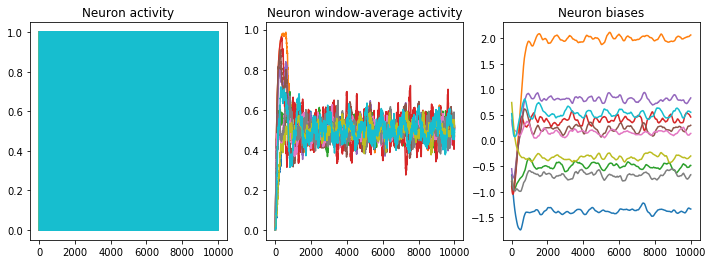

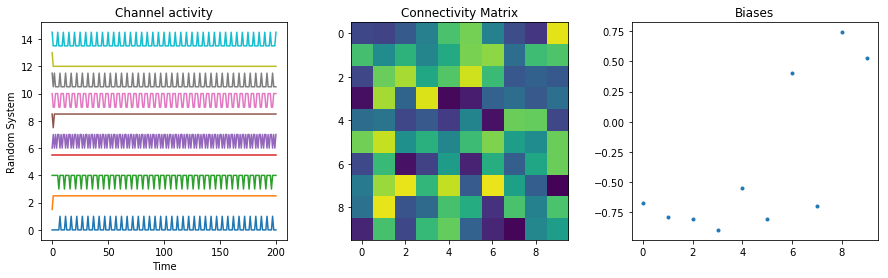

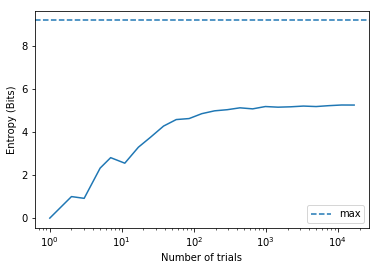

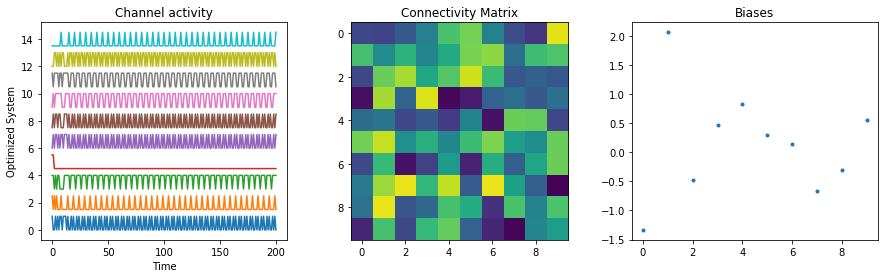

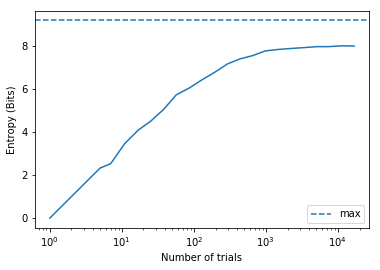

In [93]:
def dynamic_homeostatic(A, b, x0, etaY, etaB, nStep):    
    # Randomly initialize each channel
    xLst = [np.random.randint(0, 2, nChannel)]
    yLst = [np.zeros(nChannel)]
    bLst = [np.copy(b)]

    # Compute values some steps forwards
    for i in range(nStep):
        nu = (np.random.uniform(0, 1, nChannel) < 0.2).astype(int)  # Add some noise to keep system going if it dies out
        xLst += [discrete_step(xLst[-1], A, bLst[-1], nu)]
        yLst += [y_step(yLst[-1], xLst[-1], etaY)]
        bLst += [b_step(bLst[-1], yLst[-1], etaB, x0)]
        
    return xLst, yLst, bLst

A = np.random.uniform(-1, 1, (nChannel, nChannel))
b = np.random.uniform(-1, 1, nChannel)
xLst, yLst, bLst = dynamic_homeostatic(A, b, 0.5, 0.01, 0.01, 10000)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(xLst)
ax[0].set_title('Neuron activity')
ax[1].plot(yLst)
ax[1].set_title('Neuron window-average activity')
ax[2].plot(bLst)
ax[2].set_title('Neuron biases')
plt.show()

plot_performance(A, b, 200, 'Random System')
plot_test_entropy(A, b)

plot_performance(A, bLst[-1], 200, 'Optimized System')
plot_test_entropy(A, bLst[-1])

# 2.2 Synaptic Plasticity

In [77]:
def a_step(A, y, etaA, x0):
#     return np.clip(A + etaA * np.outer(y - x0, y - x0), -1, 1)
    return A + etaA * np.outer(y - x0, y - x0)

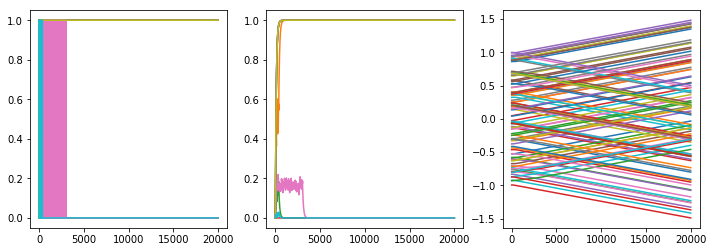

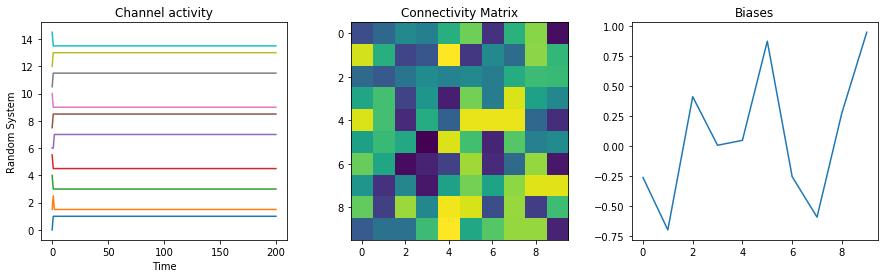

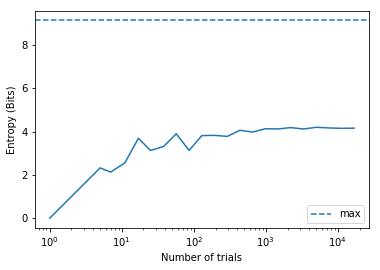

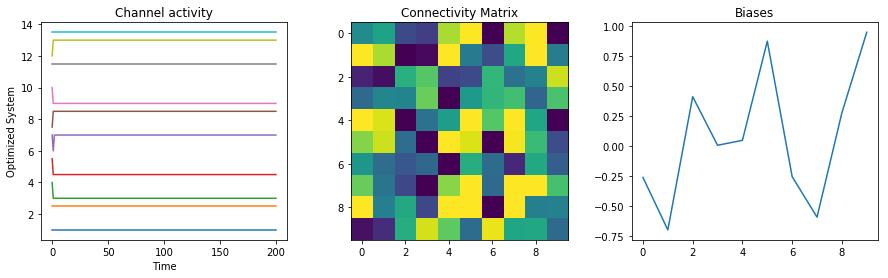

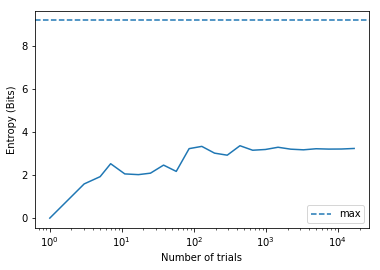

In [82]:
def dynamic_synaptic(A, b, x0, etaY, etaA, nStep):    
    # Randomly initialize each channel
    xLst = [np.random.randint(0, 2, nChannel)]
    yLst = [np.zeros(nChannel)]
    ALst = [np.copy(A)]

    # Compute values some steps forwards
    for i in range(nStep):
        nu = (np.random.uniform(0, 1, nChannel) < 0.2).astype(int)  # Add some noise to keep system going if it dies out
        xLst += [discrete_step(xLst[-1], ALst[-1], b, nu)]
        yLst += [y_step(yLst[-1], xLst[-1], etaY)]
        ALst += [a_step(ALst[-1], yLst[-1], etaA, x0)]
        
    return xLst, yLst, ALst

A = np.random.uniform(-1, 1, (nChannel, nChannel))
b = np.random.uniform(-1, 1, nChannel)
xLst, yLst, ALst = dynamic_synaptic(A, b, 0.5, 0.01, 0.0001, 20000)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(xLst)
ax[1].plot(yLst)
ax[2].plot([m.flatten() for m in ALst])
plt.show()

plot_performance(A, b, 200, 'Random System')
plot_test_entropy(A, b)

plot_performance(ALst[-1], b, 200, 'Optimized System')
plot_test_entropy(ALst[-1], b)